In [ ]:
!pip install scipy
!pip install matplotlib
!pip install pydmd
!pip install pykoopman
!pip install imageio
!pip install os
!pip install optht
!pip install derivative
!pip install lightning
!pip install imread
!pip install future
!pip install sphinx
!pip install pyvista

import os
import matplotlib.pyplot as plt
import warnings
import scipy
import imageio
warnings.filterwarnings('ignore')

from pydmd import DMD
from matplotlib import animation
from IPython.display import HTML
import numpy as np
from os import listdir
import pykoopman as pk
import pandas as pd
from imread import imread

%matplotlib inline

import future
import sphinx

from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler
from pydmd import DMDc
from numpy.testing import assert_array_almost_equal

from numpy import linalg as LA
from pydmd import CDMD

from sklearn.datasets import fetch_openml
import sys
import cv2 as cv
import plotly.io as pio
import plotly.graph_objs as go
from PIL import Image
from skimage import color
from plotly import subplots
from sklearn.model_selection import train_test_split
pio.renderers.default = "colab"
from sklearn.decomposition import SparsePCA
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.io import loadmat
import pyvista as pv
import pandas as pd

In [ ]:
def give_String_Number_For_VTK(num):

    #num: # of file to be printed

    if (num < 10):
        strNUM = '000' + np.str(num)
    elif (num < 100):
        strNUM = '00' + np.str(num)
    elif (num<1000):
        strNUM = '0' + np.str(num)
    else:
        strNUM = np.str(num)

    return strNUM

In [ ]:
def savevtk_scalar(array, filename, colorMap,dx,dy):
  nx,ny = array.shape

  with open(filename,'w') as fid:
      fid.write('# vtk DataFile Version 2.0\n')
      fid.write('Comment goes here\n')
      fid.write('ASCII\n')
      fid.write('\n')
      fid.write('DATASET STRUCTURED_POINTS\n')
        # 1 below was nz
      fid.write('DIMENSIONS    {0}   {1}   {2}\n'.format(nx, ny, 1))
      fid.write('\n')
      fid.write('ORIGIN    0.000   0.000   0.000\n')
      fid.write('SPACING   '+str(dx)+str(' ')+str(dy)+'   1.000\n')
      fid.write('\n')
        # The 1 below was nz
      fid.write('POINT_DATA   {0}\n'.format(nx*ny*1))
      fid.write('SCALARS '+colorMap+' double\n')
      fid.write('LOOKUP_TABLE default\n')
      fid.write('\n')
      for b in range(ny):
          for c in range(nx):
              fid.write('{0} '.format(array[c,b]))
          fid.write('\n')

In [ ]:
def savevtk_vector(X, Y, filename, vectorName,dx,dy):
  assert (X.shape == Y.shape), 'Error: velocity arrays of unequal size'
  nx, ny = X.shape

  XRow = X.shape[0]
  XCol = X.shape[1]
  YRow = Y.shape[0]
  YCol = Y.shape[1]

  with open(filename,'w') as fid:
      fid.write('# vtk DataFile Version 2.0\n')
      fid.write('Comment goes here\n')
      fid.write('ASCII\n')
      fid.write('\n')
      fid.write('DATASET STRUCTURED_POINTS\n')
        # 1 below was nz
      fid.write('DIMENSIONS    {0}   {1}   {2}\n'.format(nx, ny, 1))
      fid.write('\n')
      fid.write('ORIGIN    0.000   0.000   0.000\n')
        #fid.write('SPACING   1.000   1.000   1.000\n') #if want [1,32]x[1,32] rather than [0,Lx]x[0,Ly]
      fid.write('SPACING   '+str(dx)+str(' ')+str(dy)+'   1.000\n')
      fid.write('\n')
      fid.write('POINT_DATA   {0}\n'.format(nx*ny))
      fid.write('VECTORS '+vectorName+' double\n')
      fid.write('\n')
      for b in range(ny):
          for c in range(nx):
              fid.write('{0} '.format(X[c,b]))
              fid.write('{0} '.format(Y[c,b]))
              fid.write('0 ')
          fid.write('\n')

In [ ]:
def savevtk_points( X, filename, vectorName):
    N = X.shape[0]

    with open(filename,'w') as file:
        file.write('# vtk DataFile Version 2.0\n')
        file.write(vectorName+'\n')
        file.write('ASCII\n')
        file.write('DATASET UNSTRUCTURED_GRID\n\n')
        file.write('POINTS {0} float\n'.format(N))
        for ii in range(N):
            file.write('{0:.15e} {1:.15e} {2:.15e}\n'.format(X[ii,0],X[ii,1],0))
        file.write('\n')
        #
        #First: # of "Cells", Second: Total # of info inputed following
        file.write('CELLS {0} {1}\n'.format(N,2*N))
        for s in range(N):
            file.write('{0} {1}\n'.format(1,s))
        file.write('\n')
        #
        file.write('CELL_TYPES {0}\n'.format(N)) # N = # of "Cells"
        for ii in range(N):
           file.write('1 ')
        file.write('\n')


In [ ]:
def print_LBM_Info():

    print('\n\n 2D LATTICE BOLTZMANN (LBM) SIMULATION \n')
    print('Author: Nicholas A. Battista\n')
    print('Created: 11/4/2014   (MATLAB)\n')
    print('Modified: 12/2/2014  (MATLAB)\n')
    print('Created: 5/5/2017    (Python3)\n\n')
    print('_____________________________________________________________________________\n\n')
    print('D2Q9 Model:\n\n')
    print('c6  c2   c5\n')
    print('  \\  |  /  \n')
    print('c3- c9 - c1\n')
    print('  /  |  \\  \n')
    print('c7  c4   c8\n\n')
    print('f_i: the probability for site vec(x) to have a particle heading in\n')
    print('direction i, at time t. These f_i''s are called discretized probability \n')
    print('distribution functions\n\n')
    print('_____________________________________________________________________________\n\n')
    print('LBM Idea: \n')
    print('1. At each timestep the particle densities propogate in each direction (1-8).\n')
    print('2. An equivalent "equilibrium" density is found\n')
    print('3. Densities relax towards that state, in proportion governed by tau\n')
    print('#s (parameter related to viscosity)\n\n','  ')
    print('_____________________________________________________________________________\n\n')


In [ ]:
all_UX_data_frames = []
all_UY_data_frames = []
#all_velocity_data_frames = []

def print_vtk_files(ctsave,U,V,vorticity,Lx,Ly,nx,ny,Bound_Pts):

    #Give spacing for grid
    dx = Lx/(nx-1)
    dy = Ly/(ny-1)

    #Go into vtk_data directory. This was throwing an error because we're already there!
    if os.path.split(os.getcwd())[1] != 'vtk_data':
        os.chdir('vtk_data')

    #Find string number for storing files
    strNUM = give_String_Number_For_VTK(ctsave)

    #Print Boundary Pts to .vtk format
    lagPtsName = 'Bounds.'+strNUM+'.csv'
    savevtk_points(Bound_Pts, lagPtsName, 'Bounds')

    #Prints x-Velocity Component
    confName = strNUM + '.uX' + '.csv'
    savevtk_scalar(U, confName, 'uX',dx,dy)

    #Prints y-Velocity Component
    confName = strNUM + '.uY' + '.csv'
    savevtk_scalar(V, confName, 'uY',dx,dy)

    #Prints Mag. of Velocity
    confName = 'uMag.' + strNUM + '.csv'
    uMag = np.sqrt(U*U + V*V)
    savevtk_scalar(uMag, confName, 'uMag',dx,dy)

    #Prints Vorticity
    confName = 'Omega.' + strNUM + '.csv'
    savevtk_scalar(vorticity, confName, 'Omega',dx,dy)

    #Print VECTOR DATA (i.e., velocity data) to .vtk file
    velocityName = 'u.' + strNUM + '.csv'
    savevtk_vector(U, V, velocityName, 'u',dx,dy)

    ux_columns = [f'UX_{i}' for i in range(ny)]
    uy_columns = [f'UY_{i}' for i in range(ny)]
    ux_df = pd.DataFrame(U, columns=ux_columns)
    uy_df = pd.DataFrame(V, columns=uy_columns)
    #velocity_df = pd.DataFrame(velocity_magnitude)

    all_UX_data_frames.append(ux_df.values)
    all_UY_data_frames.append(uy_df.values)
    #all_velocity_data_frames.append(velocity_df.values)

    # Save UX and UY data frames to variables
    global saved_UX, saved_UY
    saved_UX = ux_df.copy()
    saved_UY = uy_df.copy()

    os.chdir('..')


In [ ]:
import numpy as np
import numpy.matlib as matlib
from scipy import misc, fftpack
import os
import time

In [ ]:
def print_simulation_info(choice):

    if (choice=='channel'):

        print('You are simulating CHANNEL FLOW\n')
        print('Flow proceeds left to right through the channel\n')
        print('You should see a parabolic flow profile develop\n\n\n')

    elif (choice=='cylinder1'):

        print('You are simulating flow around a cylinder\n')
        print('Flow proceeds left to right through the channel containing a 2D cylinder\n')
        print('You should see flow wrapping around the cylinder\n')
        print('Try changing the tau (viscosity) to observe differing dynamics\n\n\n')

    elif (choice=='cylinder2'):

        print('You are simulating flow around a field of cylinders\n')
        print('Flow proceeds left to right through the channel containing 2D cylinders\n')
        print('You should see flow wrapping around the cylinders\n')
        print('Try changing the tau (viscosity) to observe differing dynamics\n')
        print('Also try adding cylinders or changing their place in the "give_Me_Problem_Geometry" function\n\n\n')

    elif (choice=='porous1'):

        print('You are simulating porous media flow\n')
        print('Flow proceeds left to right through the channel containing obstacles\n')
        print('Try changing the porosity (percentPorosity) to observe differing dynamics\n')
        print('NOTE: each simulation creates a RANDOM porous geometry\n\n\n')

    elif (choice=='porous2'):

        print('You are simulating flow through various porous layers\n')
        print('Flow proceeds left to right through the channel containing obstacles\n')
        print('Try changing the porosity (percentPorosity) to observe differing dynamics\n')
        print('NOTE: each simulation creates a RANDOM porous geometry\n\n\n')


In [ ]:
def give_Me_Boundary_Pts_For_Visualization(dx,dy,Nx,Ny,Lx,Ly,ON_i,ON_j):

    aX = np.arange(Lx-dx,-dx,-dx)
    xMat = np.tile(aX,[Ny,1])           # MATLAB: xMat = repmat(Lx-dx:-dx:0,Nx).T

    aY = np.arange(0,Ly,dy)
    yMat = np.tile(aY,[Nx,1]).T         # MATLAB: yMat = repmat(0:dy:Ly,Ny)

    xBounds = xMat[ON_i,ON_j]
    xBounds = -xBounds + Lx
    yBounds = yMat[ON_i,ON_j]



    lenX = len(xBounds)
    Bound_Pts = np.zeros((lenX,2))

    for i in range(0,lenX):
        Bound_Pts[i,0] = xBounds[i]
        Bound_Pts[i,1] = yBounds[i]

    # TEST PLOTTING IN MATLAB -> CONVERT TO PYTHON ONE DAY
    #subplot(1,2,1)
    #image(2-BOUND') hold on
    #subplot(1,2,2)
    #plot(Bound_Pts(:,1),Bound_Pts(:,2),'*')
    #pause()

    return Bound_Pts

In [ ]:
def give_Me_Problem_Geometry(choice,Nx,Ny,percentPorosity):


    if (choice=='channel'):

        #CHANNEL GEOMETRY
        BOUNDs=np.zeros((Nx,Ny))
        BOUNDs[0:,[0,Ny-1]]=1.0            # PUTS "1's" on LEFT/RIGHT Boundaries
        deltaU = 0.01                      # Incremental increase to inlet velocity
        endTime = 2500

    elif (choice=='porous1'):

        #POROUS RANDOM DOMAIN
        BOUNDs=np.random.rand(Nx,Ny)<(1-percentPorosity)   # Puts TRUE/FALSE's inside domain randomly if RAND value above percent
        BOUNDs=BOUNDs.astype(int)                          # Converts Boolean matrix to matrix of 0,1's
        aS = int(np.ceil(Nx/5))                            # Puts openings near ends of porous channel
        aE = int(np.ceil(4*Nx/5))                          # Puts openings near ends of porous channel
        BOUNDs[0:aS,:] = 0                                 # Puts openings near ends of porous channel
        BOUNDs[aE:,:]=0                                    # Puts openings near ends of porous channel
        BOUNDs[0:,[0,Ny-1]]=1                              # Puts "1's" on LEFT/RIGHT Boundaries
        deltaU = 1e-7                                      # Incremental increase to inlet velocity
        endTime = 5000

    elif (choice=='porous2'):

        #POROUS RANDOM DOMAIN
        BOUNDs=np.random.rand(Nx,Ny)<(1-percentPorosity)                 # PUTS "1's" inside domain randomly if RAND value above percent
        BOUNDs[np.arange(0,int(np.floor(9*Nx/31)),1),:] = 0                        # PUTS "0's" to make open channels through porous structure
        BOUNDs[np.arange(int(np.floor(7*Nx/31)),int(np.ceil(9*Nx/31)),1),:] = 0    # PUTS "0's" to make open channels through porous structure
        BOUNDs[np.arange(int(np.floor(13*Nx/31)),int(np.ceil(15*Nx/31)),1),:] = 0  # PUTS "0's" to make open channels through porous structure
        BOUNDs[np.arange(int(np.floor(19/31*Nx)),int(np.ceil(21/31*Nx)),1),:] = 0  # PUTS "0's" to make open channels through porous structure
        BOUNDs[np.arange(int(np.floor(25/31*Nx)),int(np.ceil(27/31*Nx)),1),:]=0    # PUTS "0's" to make open channels through porous structure
        BOUNDs[int(np.floor(30/31*Nx)):,:] = 0                                     # PUTS "0's" to make open channels through porous structure
        BOUNDs[0:,[0,Ny-1]]= 1                                           # PUTS "1's" on LEFT/RIGHT Boundaries
        deltaU = 1e-7                                                    # Incremental increase to inlet velocity
        endTime = 5000


    elif (choice=='cylinder1'):

        #CHANNEL FLOW W/ CYLINDER

        # radii of cylinder (given in terms of mesh widths)
        radius1 = 0.075*Ny

        # auxillary vectors
        xAux = np.arange(-(Nx-1)/2, (Nx-1)/2+1, 1)
        yAux = np.arange(-(Ny-1)/2, (Ny-1)/2+1, 1)

        # stack vectors to create grids of indices
        a1=np.tile(xAux,(Ny,1))
        a2=np.tile(yAux,(Nx,1))

        # Amount to translate cylinder from middle of domain
        aR = np.floor(0.375*Nx)

        # Create Cylinder Geometry (Note: "+" shifts left bc of defining circles)
        BOUNDs= ( (a1+aR)**2+((a2).T)**2) < radius1**2     # Puts "1's" within Cylinder Region

        # Convert to 0,1 boolean matrix from False,True matrix
        BOUNDs = BOUNDs.astype(int)

        # Create Top/Bottom Boundaries
        BOUNDs[[0,Ny-1],0:] = 1              # Puts "1's" on Top/Bottom Boundaries

        deltaU = 0.00125                     # Incremental increase to inlet velocity
        endTime = 56000                      # Total Number of Time-Steps


    elif (choice=='cylinder2'):

        #CHANNEL FLOW W/ MULTIPLE CYLINDERS

        # radii of cylinder (given in terms of mesh widths)
        radius1 = 0.125*Ny

        # auxillary vectors
        xAux = np.arange(-(Nx-1)/2, (Nx-1)/2+1, 1)
        yAux = np.arange(-(Ny-1)/2, (Ny-1)/2+1, 1)

        # stack vectors to create grids of indices
        a1=np.tile(xAux,(Ny,1))
        a2=np.tile(yAux,(Nx,1))

        # Amount to translate cylinder from middle of domain
        aR = np.floor(0.375*Nx)
        aSx = np.floor(0.1*Nx)
        aY = np.floor(0.2*Ny)

        # Create Cylinder Geometry (Note: "+" shifts left bc of defining circles)
        B1 = ( (a1+aR)**2+((a2).T)**2) < radius1**2            # Puts "1's" within Cylinder Region
        B2 = ( (a1+aR-aSx)**2+((a2-aY).T)**2) < radius1**2     # Puts "1's" within Cylinder Region
        B3 = ( (a1+aR-aSx)**2+((a2+aY).T)**2) < radius1**2     # Puts "1's" within Cylinder Region

        # Convert to 0,1 boolean matrix from False,True matrix
        B1 = B1.astype(int)
        B2 = B2.astype(int)
        B3 = B3.astype(int)

        # Combine boolean matrices
        # Note: here assuming no overlapping vorticity regions
        BOUNDs = B1 + B2 + B3

        # Create Top/Bottom Boundaries
        BOUNDs[[0,Ny-1],0:] = 1              # Puts "1's" on Top/Bottom Boundaries

        deltaU = 0.01                     # Incremental increase to inlet velocity
        endTime = 5500                    # Total Number of Time-Steps


    elif (choice=='porousCylinder'):

        #CHANNEL FLOW AROUND POROUS CYLINDER

        # radii of cylinder (given in terms of mesh widths)
        radius1 = 0.075*Ny

        # auxillary vectors
        xAux = np.arange(-(Nx-1)/2, (Nx-1)/2+1, 1)
        yAux = np.arange(-(Ny-1)/2, (Ny-1)/2+1, 1)

        # stack vectors to create grids of indices
        a1=np.tile(xAux,(Ny,1))
        a2=np.tile(yAux,(Nx,1))

        # Amount to translate cylinder from middle of domain
        aR = np.floor(0.375*Nx)

        # Create Cylinder Geometry (Note: "+" shifts left bc of defining circles)
        BOUNDs= ( (a1+aR)**2+((a2).T)**2) < radius1**2     # Puts "1's" within Cylinder Region

        # Convert to DOUBLE matrix from False,True matrix
        BOUNDs = np.double(BOUNDs)

        # Find non-zero indices, e.g., where cylinder is
        ind1,ind2 = np.nonzero(BOUNDs)

        # Replace 1's with Random Value from [0,1]
        for i in range(0,len(ind1)):
            BOUNDs[ind1[i],ind2[i]] = np.random.rand()

        # Make Porosity Statement
        BOUNDs = (BOUNDs>percentPorosity) # PUTS "1's" inside domain randomly if RAND value above percent

        # Convert to 0,1 boolean matrix from False,True matrix
        BOUNDs = BOUNDs.astype(int)

        # Create Top/Bottom Boundaries
        BOUNDs[[0,Ny-1],0:] = 1              # Puts "1's" on Top/Bottom Boundaries

        deltaU = 0.00125                     # Incremental increase to inlet velocity
        endTime = 56000                      # Total Number of Time-Steps



    #
    # Reverse Order of BOUND for GEOMETRY (top is initialized as bottom and vice versa)
    #
    Bound2 = np.zeros( BOUNDs.shape )
    for i in range(0,Ny):
        Bound2[i,0:] = BOUNDs[Ny-1-i,0:]

    return BOUNDs, Bound2, deltaU, endTime


In [ ]:
def please_Stream_Distribution(f,Nx,Ny):

    xInds = np.arange(0,Nx,1)                # Indices Vector 0,1,...,Ny-1
    yInds = np.arange(0,Ny,1)                # Indices Vector 0,1,...,Nx-1


    # STREAM RIGHT
    a1=np.array([Nx-1])
    a2=np.arange(0,Nx-1,1)
    inds = np.concatenate((a1, a2), axis=0)
    f[0,xInds,:] =f[0,inds,:]                 #Stream Right


    # STREAM UP
    a1=np.array([Ny-1])
    a2=np.arange(0,Ny-1,1)
    inds = np.concatenate((a1, a2), axis=0)
    f[1,:,yInds] =f[1,:,inds]                 #Stream Up


    # STREAM LEFT
    a1=np.array([0])
    a2=np.arange(1,Nx,1)
    inds = np.concatenate((a2, a1), axis=0)
    f[2,xInds,:] =f[2,inds,:]                #Stream Left


    # STREAM DOWN
    a1=np.array([0])
    a2=np.arange(1,Ny,1)
    inds = np.concatenate((a2, a1), axis=0)
    f[3,:,yInds] =f[3,:,inds]                #Stream Down


    # STREAM RIGHT-UP!
    a1=np.array([Nx-1]); a2=np.arange(0,Nx-1,1)
    inds = np.concatenate((a1, a2), axis=0)
    b1=np.array([Ny-1]); b2=np.arange(0,Ny-1,1)
    indsY = np.concatenate((b1, b2), axis=0)
    f[4,xInds,:] =f[4,inds,:]            #Stream Right
    f[4,:,yInds] =f[4,:,indsY]           #Stream Up


    # STREAM LEFT-UP!
    a1=np.array([0]); a2=np.arange(1,Nx,1)
    inds = np.concatenate((a2, a1), axis=0)
    b1=np.array([Ny-1]); b2=np.arange(0,Ny-1,1)
    indsY = np.concatenate((b1, b2), axis=0)
    f[5,xInds,:] =f[5,inds,:]            #Stream Left
    f[5,:,yInds] =f[5,:,indsY]           #Stream Up


    # STREAM LEFT-DOWN
    a1=np.array([0]); a2=np.arange(1,Nx,1)
    inds = np.concatenate((a2, a1), axis=0)
    b1=np.array([0]); b2=np.arange(1,Ny,1)
    indsY = np.concatenate((b2, b1), axis=0)
    f[6,xInds,:] =f[6,inds,:]            #Stream Left
    f[6,:,yInds] =f[6,:,indsY]           #Stream Down


    # STREAM RIGHT-DOWN
    a1=np.array([Nx-1]); a2=np.arange(0,Nx-1,1)
    inds = np.concatenate((a1, a2), axis=0)
    b1=np.array([0]); b2=np.arange(1,Ny,1)
    indsY = np.concatenate((b2, b1), axis=0)
    f[7,xInds,:] =f[7,inds,:]            #Stream Right
    f[7,:,yInds] =f[7,:,indsY]           #Stream Down


    return f

In [ ]:
def please_Give_Equilibrium_Distribution(w1,w2,w3,DENSITY,UX,UY,U_SQU,U_5,U_6,U_7,U_8,f_EQ):

    # Calculate equilibrium distribution: stationary pt in middle.
    f_EQ[8,:,:] = w1*DENSITY * (1 - (3/2)*U_SQU )


    # NEAREST-neighbours (i.e., stencil pts directly right,left,top,bottom)
    # Equilibrium DFs can be obtained from the local Maxwell-Boltzmann SPDF
    f_EQ[0,:,:] = w2*DENSITY * (1 + 3*UX + (9/2)*(UX*UX) - (3/2)*U_SQU )
    f_EQ[1,:,:] = w2*DENSITY * (1 + 3*UY + (9/2)*(UY*UY) - (3/2)*U_SQU )
    f_EQ[2,:,:] = w2*DENSITY * (1 - 3*UX + (9/2)*(UX*UX) - (3/2)*U_SQU )
    f_EQ[3,:,:] = w2*DENSITY * (1 - 3*UY + (9/2)*(UY*UY) - (3/2)*U_SQU )

    # NEXT-NEAREST neighbours (i.e., diagonal elements for stencil pts)
    # Equilibrium DFs can be obtained from the local Maxwell-Boltzmann SPDF
    f_EQ[4,:,:] = w3*DENSITY * (1 + 3*U_5 + (9/2)*(U_5*U_5) - (3/2)*U_SQU )
    f_EQ[5,:,:] = w3*DENSITY * (1 + 3*U_6 + (9/2)*(U_6*U_6) - (3/2)*U_SQU )
    f_EQ[6,:,:] = w3*DENSITY * (1 + 3*U_7 + (9/2)*(U_7*U_7) - (3/2)*U_SQU )
    f_EQ[7,:,:] = w3*DENSITY * (1 + 3*U_8 + (9/2)*(U_8*U_8) - (3/2)*U_SQU )

    return f_EQ


In [ ]:
def create_image_directory(directory_name):
    try:
        os.mkdir(directory_name)
    except FileExistsError:
        pass

def save_figure_to_image_directory(figure, directory_name, step):
    filename = f"figure_{step}.png"
    filepath = os.path.join(directory_name, filename)
    figure.savefig(filepath)

In [ ]:
def save_figure_to_image_directory2(figure, directory_name, step, width=1.6, height=6.4, dpi=100):
    filename = f"figure_{step}.png"
    filepath = os.path.join(directory_name, filename)

    # Save the figure without whitespace and with the specified DPI
    figure.savefig(filepath, bbox_inches='tight', dpi=dpi)


In [ ]:
def lets_do_LBM():
    #Prints key ideas to screen
    #print_LBM_Info()

    # Simulation Parameters
    tau=0.53                               # Tau: relaxation parameter related to viscosity
    density=0.01                           # Density to be used for initializing whole grid to value 1.0
    w1=4/9; w2=1/9; w3=1/36                # Weights for finding equilibrium distribution
    Nx=640; Ny=160                         # Number of grid cells
    Lx = 2; Ly = 0.5                       # Size of computational domain
    dx = Lx/Nx; dy = Ly/Ny                 # Grid Resolutions in x and y directions, respectively

    # Chooses which problem to simulate
    # Possible Choices: 'cylinder1', 'cylinder2', 'porousCylinder'
    #
    choice = 'cylinder1'
    percentPorosity = 0.525  # Percent of Domain that's Porous (does not matter if not studying porous problem)
    BOUND, Bound2, deltaU, endTime = give_Me_Problem_Geometry(choice,Nx,Ny,percentPorosity) #BOUND: gives geometry, deltaU: gives incremental increase to inlet velocity
    print_simulation_info(choice)

    # Gridding Initialization
    #
    f = density/9.0*np.ones((9,Nx,Ny))     # Copies density/9 into 9-matrices of size [Nx,Ny] -> ALLOCATION for all "DIRECTIONS"
    f_EQ = density/9.0*np.ones((9,Nx,Ny))  # Initializes F-equilibrium Storage space
    grid_size= Nx*Ny                       # Total number of grid cells
    CI= np.arange(0,8*grid_size,grid_size) # Indices to point to FIRST entry of the desired "z-stack" distribution grid

    #Find Indices of NONZERO Elements, i.e., where "boundary points" are
    ON_i,ON_j = np.nonzero(BOUND.T)       # matrix offset of each Occupied Node e.g., A(ON_i,ON_j) ~= 0
    On2_i,On2_j = np.nonzero(Bound2)      # matrix index of each occupied node for visualization data
    BOUNCEDBACK = np.zeros((ON_i.size,8))

    # Give Boundary Points For Saving Data
    Bound_Pts = give_Me_Boundary_Pts_For_Visualization(dx,dy,Nx,Ny,Lx,Ly,On2_i,On2_j)

    #Initialization Parameters
    ts=0                              # initialize starting time to 0 (time-step)
    print('Simulation Time: {0:6.6f}\n'.format(ts))


    # SAVING DATA TO VTK #
    print_dump = 100 #int(np.floor(endTime/50))  # number of time-steps between data storage
    ctsave = 0                              # Counts # of total time-steps
    pSave = 0                               # Counts total number of time-steps with data saved
    #endtime = 56000

    # CREATE VTK DATA FOLDER
    try:
        os.mkdir('vtk_data')
    except FileExistsError:
        #File already exists
        pass

    # INITIALIZE DATA STORAGE #
    UX = np.zeros((Nx,Ny))                                          # Initialize x-Component of Velocity
    UY = np.zeros((Nx,Ny))                                          # Initialize y-Component of Velocity
    vorticity = np.zeros((Nx-1,Ny-1))

    # Lists to store data for plotting
    UX_list = []
    UY_list = []
    vorticity_list = []
    velocity_magnitude_list = []

    # Initialize Vorticity
    print_vtk_files(pSave,UX,UY,vorticity,Lx,Ly,Nx,Ny,Bound_Pts)   # Print .vtk files for initial configuration


    #Begin time-stepping!
    while ( ts < endTime ):


        # STREAMING STEP (progate in respective directions)
        f = please_Stream_Distribution(f,Nx,Ny)


        #Densities bouncing back at next timestep
        #BOUNCEDBACK=f(TO_REFLECT)
        BOUNCEDBACK[:,0] = f[0,ON_i,ON_j]
        BOUNCEDBACK[:,1] = f[1,ON_i,ON_j]
        BOUNCEDBACK[:,2] = f[2,ON_i,ON_j]
        BOUNCEDBACK[:,3] = f[3,ON_i,ON_j]
        BOUNCEDBACK[:,4] = f[4,ON_i,ON_j]
        BOUNCEDBACK[:,5] = f[5,ON_i,ON_j]
        BOUNCEDBACK[:,6] = f[6,ON_i,ON_j]
        BOUNCEDBACK[:,7] = f[7,ON_i,ON_j]

        #time.sleep(2.0)

        #vec(rho) = SUM_i f_i -> SUMS EACH DISTRIBUTION MATRIX TOGETHER
        DENSITY=sum(f)  # Note: denotes sum over third dimension

        #vec(u) = 1/vec(rho) SUM_i (f_i)(e_i) -> CREATES VELOCITY MATRICES
        UX = ( ( f[0,:,:] + f[4,:,:] + f[7,:,:] ) - ( f[2,:,:] + f[5,:,:] + f[6,:,:]) ) / DENSITY
        # MATLAB: UX=( sum(f(:,:,[1 5 8]),3)-sum(f(:,:,[3 6 7]),3) ) ./ DENSITY
        UY = ( ( f[1,:,:] + f[4,:,:] + f[5,:,:] ) - ( f[3,:,:] + f[6,:,:] + f[7,:,:]) ) / DENSITY
        # MATLAB: UY=( sum(f(:,:,[2 5 6]),3)-sum(f(:,:,[4 7 8]),3) ) ./ DENSITY

        #Increase inlet velocity with each time step along left wall
        UX[0,1:Ny] = UX[0,1:Ny] + deltaU


        #Enforce BCs to Zero Velocity / Zero Density
        UX[ON_i,ON_j] = 0      # Makes all Boundary Regions have zero x-velocity -> MATLAB: UX(ON)=0
        UY[ON_i,ON_j] = 0      # Makes all Boundary Regions have zero y-velocity -> MATLAB: UY(ON)=0
        DENSITY[ON_i,ON_j] = 0 # Makes DENSITY of Boundary Regions have zero value -> MATLAB: DENSITY(ON)=0


        #Square of Magnitude of Velocity Overall
        U_SQU = UX*UX + UY*UY


        #Create "Diagonal" Velocity Quantities
        U_5 =  UX+UY #Create velocity direction to Point 5
        U_6 = -UX+UY #Create velocity direction to Point 6
        U_7 = -U_5   #Create velocity direction to Point 7
        U_8 = -U_6   #Create velocity direction to Point 8

        #Calculate the equilibrium distribution
        f_EQ = please_Give_Equilibrium_Distribution(w1,w2,w3,DENSITY,UX,UY,U_SQU,U_5,U_6,U_7,U_8,f_EQ)


        #Update the PDFs
        f = f - (1/tau)*(f-f_EQ)


        #BOUNCE BACK DENSITIES for next time-step
        #f(REFLECTED) = BOUNCEDBACK
        #REFLECTED= [ON+CI(3) ON+CI(4) ON+CI(1) ON+CI(2) ON+CI(7) ON+CI(8) ON+CI(5) ON+CI(6)]
        #REFLECTED= [   CI(3)     CI(4)     CI(1)     CI(2)     CI(7)     CI(8)     CI(5)     CI(6)  ]
        #REFLECTED= [ 3rd_grid  4th_grid  1st_grid  2nd_grid  7th_grid  8th_grid  5th_grid  6th_grid ] (MATLAB)
        #REFLECTED= [ 2nd lvl   3rd lvl   0th lvl   1st lvl   6th lvl   7th lvl   4th lvl   5th lvl  ] (PYTHON)

        #BOUNCE BACK DENSITIES for next time-step
        f[2,ON_i,ON_j] = BOUNCEDBACK[:,0]
        f[3,ON_i,ON_j] = BOUNCEDBACK[:,1]
        f[0,ON_i,ON_j] = BOUNCEDBACK[:,2]
        f[1,ON_i,ON_j] = BOUNCEDBACK[:,3]
        f[6,ON_i,ON_j] = BOUNCEDBACK[:,4]
        f[7,ON_i,ON_j] = BOUNCEDBACK[:,5]
        f[4,ON_i,ON_j] = BOUNCEDBACK[:,6]
        f[5,ON_i,ON_j] = BOUNCEDBACK[:,7]


        #Updates simulation parameters
        ts=ts+1   # update time step

        # Save files info!
        ctsave = ctsave + 1
        if (ctsave % print_dump) == 0:

            # increment pSave counter
            pSave = pSave + 1

            # compute vorticity
            dUx_y = ( UX[0:Nx-1,1:Ny] - UX[0:Nx-1,0:Ny-1] ) / dy
            dUy_x = ( UY[1:Nx,0:Ny-1] - UY[0:Nx-1,0:Ny-1] ) / dx
            vorticity[0:Nx-1,0:Ny-1] = dUy_x - dUx_y

            plt.figure(figsize=(10, 5))

            # Plot velocity magnitude
            #plt.subplot(1, 2, 1)
            velocity_magnitude = np.sqrt(UX**2 + UY**2)
            plt.imshow(velocity_magnitude, cmap='jet')
            plt.axis('off')
            #plt.title(f'Velocity Magnitude - Step {ts}')
            #plt.colorbar()

            # Plot vorticity
            #plt.subplot(1, 2, 2)
            #plt.imshow(vorticity, cmap='jet')
            #plt.title(f'Vorticity - Step {ts}')
            #plt.colorbar()

            plt.tight_layout()
            #save_figure_to_image_directory2(plt, '/content/images', ts)

            plt.show()

            UX_list.append(UX.copy())
            UY_list.append(UY.copy())
            vorticity_list.append(vorticity.copy())
            velocity_magnitude_list.append(velocity_magnitude.copy())

            # print to vtk
            print_vtk_files(pSave,UX,UY,vorticity,Lx,Ly,Nx,Ny,Bound_Pts)
            print('Simulation Time: {0:6.6f}\n'.format(ts))

        #return UX_list, UY_list, vorticity_list, velocity_magnitude_list

#### ENDS MAIN TIME-STEPPING ROUTINE #####


if __name__ == "__main__":
  lets_do_LBM()


In [ ]:
# Create 3D arrays
UX_3D_array = np.stack(all_UX_data_frames, axis=-1)
UY_3D_array = np.stack(all_UY_data_frames, axis=-1)
#velocity_3D_array = np.stack(all_velocity_data_frames, axis=-1)

In [ ]:
velocity_3D_array[:, :, 1].shape

(320, 640)

In [ ]:
plt.figure(figsize=(10, 5))
velocity_magnitude2 = np.sqrt(UX_3D_array[:, :, 10].T**2 + UY_3D_array[:, :, 10].T**2)
plt.imshow(velocity_magnitude2.T, cmap='jet')
plt.axis('off')
plt.tight_layout()
plt.show

In [ ]:
UX_3D_array.shape[2]

561

In [ ]:
#velocity_magnitude_3D_array = np.empty_like(UX_3D_array)

velocity_magnitude_3D_array = np.empty(shape=(160, 640, 561))

# Loop through each frame and calculate velocity magnitudes
for frame_index in range(UX_3D_array.shape[2]):
    UX_frame = UX_3D_array[:, :, frame_index]
    UY_frame = UY_3D_array[:, :, frame_index]
    velocity_magnitude_frame = np.sqrt(UX_frame.T**2 + UY_frame.T**2)
    velocity_magnitude_3D_array[:, :, frame_index] = velocity_magnitude_frame

# Now velocity_magnitude_3D_array contains velocity magnitudes for each frame

# Access a specific instance of velocity magnitude
#specific_velocity_magnitude_instance = velocity_magnitude_3D_array[:, :, 10]  # Replace with desired instance index

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(velocity_magnitude_3D_array[:, :, 510].T, cmap='jet')
plt.axis('off')
plt.tight_layout()
plt.show

In [ ]:
velocity_magnitude_2D_array = np.empty(shape=(102400, 561))

# Loop through each frame and calculate velocity magnitudes
for frame_index in range(UX_3D_array.shape[2]):
    UX_frame = UX_3D_array[:, :, frame_index]
    UY_frame = UY_3D_array[:, :, frame_index]
    velocity_magnitude_frame = np.sqrt(UX_frame.T**2 + UY_frame.T**2)
    velocity_magnitude_frame = velocity_magnitude_frame.flatten()
    velocity_magnitude_2D_array[:, frame_index] = velocity_magnitude_frame


In [ ]:
velocity_magnitude_2D_array.shape

(102400, 561)

<function matplotlib.pyplot.show(close=None, block=None)>

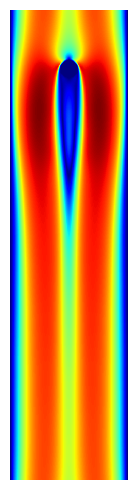

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(velocity_magnitude_2D_array[:, 315].reshape(160,640).T, cmap='jet')
plt.axis('off')
plt.tight_layout()
plt.show

In [ ]:
velocity_magnitude_2D_array[:, 315].reshape(160,640).T

array([[0.        , 0.00350175, 0.01004345, ..., 0.01004345, 0.00350175,
        0.        ],
       [0.        , 0.00342799, 0.00996955, ..., 0.00996955, 0.00342799,
        0.        ],
       [0.        , 0.00344625, 0.01001279, ..., 0.01001279, 0.00344625,
        0.        ],
       ...,
       [0.        , 0.00341319, 0.00991531, ..., 0.00991531, 0.00341319,
        0.        ],
       [0.        , 0.00342611, 0.00995   , ..., 0.00995   , 0.00342611,
        0.        ],
       [0.        , 0.00343716, 0.00998076, ..., 0.00998076, 0.00343716,
        0.        ]])

In [ ]:
Z = velocity_magnitude_2D_array

# Perform DMD
dmd = DMD(svd_rank=0)
dmd.fit(Z)

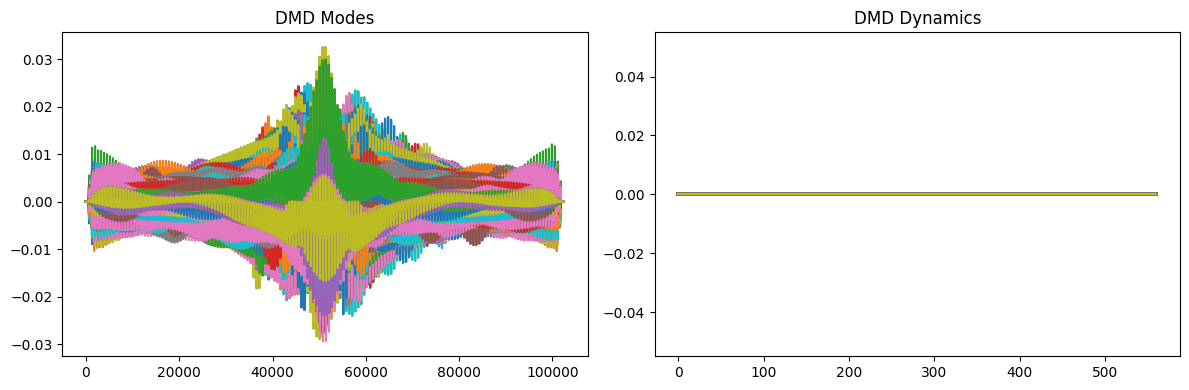

In [ ]:
modes = dmd.modes.T
dynamics = dmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in modes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in dynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()

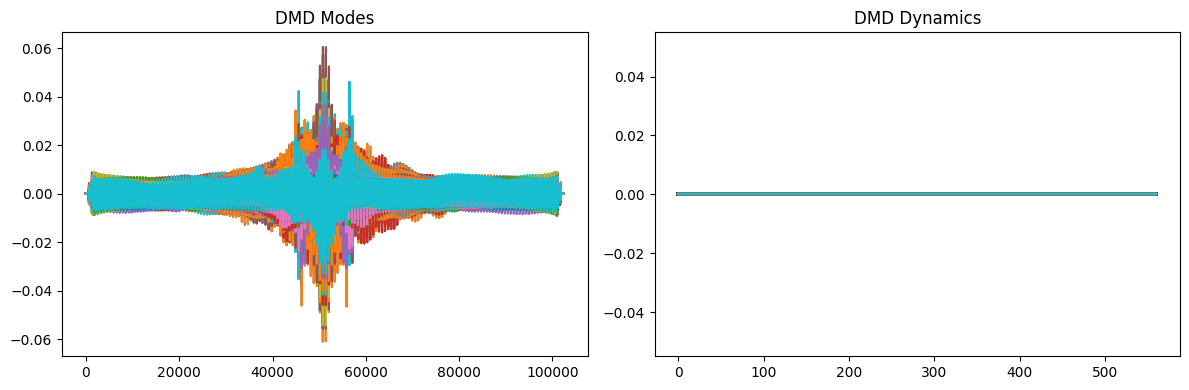

In [ ]:
Z = velocity_magnitude_2D_array

# Perform DMD
dmd = DMD(svd_rank=561)
dmd.fit(Z)

# Access DMD modes and dynamics
modes = dmd.modes.T
dynamics = dmd.dynamics

# Visualize DMD modes and dynamics
plt.figure(figsize=(12, 4))

# Plot DMD modes
plt.subplot(1, 2, 1)
for mode in modes:
    plt.plot(mode)
plt.title('DMD Modes')

# Plot DMD dynamics
plt.subplot(1, 2, 2)
for dynamic in dynamics:
    plt.plot(dynamic)
plt.title('DMD Dynamics')

plt.tight_layout()
plt.show()

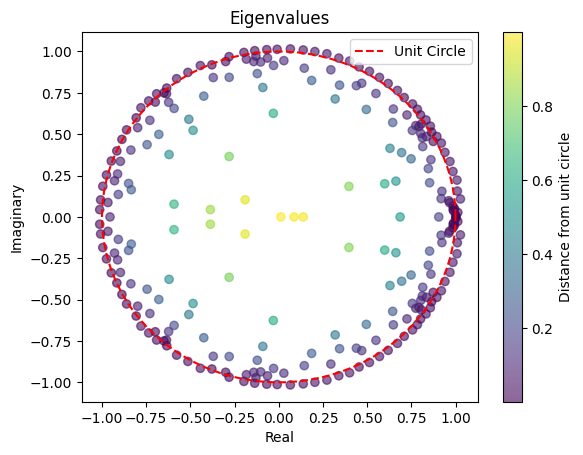

In [ ]:
eigenvalues = dmd.eigs

# Calculate distance from unit circle
distances = np.abs(eigenvalues.imag**2 + eigenvalues.real**2 - 1)

# Plot eigenvalues and unit circle
plt.figure()
plt.scatter(eigenvalues.real, eigenvalues.imag, c=distances, cmap='viridis', alpha=0.6)
plt.colorbar(label='Distance from unit circle')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Eigenvalues')

# Plot unit circle
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), color='red', linestyle='--', label='Unit Circle')
plt.legend()

plt.show()

In [ ]:
approximate = dmd.reconstructed_data
approximate = approximate.astype(np.float)
approximate.shape

(102400, 561)

<function matplotlib.pyplot.show(close=None, block=None)>

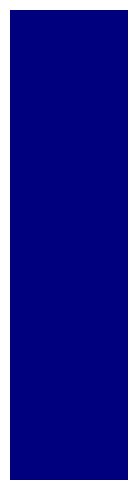

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(approximate[:, 4].reshape(160,640).T, cmap='jet')
plt.axis('off')
plt.tight_layout()
plt.show

In [ ]:
import shutil
shutil.make_archive('/content/images', 'zip', '/content/images')